In [1]:
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline

In [87]:
# Starting with example at
# https://matplotlib.org/examples/api/radar_chart.html

from matplotlib.path import Path
from matplotlib.spines import Spine
from matplotlib.projections.polar import PolarAxes
from matplotlib.projections import register_projection

def radar_factory(num_vars, frame='circle'):
    """Create a radar chart with `num_vars` axes.

    This function creates a RadarAxes projection and registers it.

    Parameters
    ----------
    num_vars : int
        Number of variables for radar chart.
    frame : {'circle' | 'polygon'}
        Shape of frame surrounding axes.

    """
    # calculate evenly-spaced axis angles
    theta = np.linspace(0, 2*np.pi, num_vars, endpoint=False)
    # rotate theta such that the first axis is at the top
    theta += np.pi/2
    
    # FFS, need to make sure we don't go over 360
    theta = theta % (2.*np.pi)

    def draw_poly_patch(self):
        verts = unit_poly_verts(theta)
        return plt.Polygon(verts, closed=True, edgecolor='k')

    def draw_circle_patch(self):
        # unit circle centered on (0.5, 0.5)
        return plt.Circle((0.5, 0.5), 0.5)

    patch_dict = {'polygon': draw_poly_patch, 'circle': draw_circle_patch}
    if frame not in patch_dict:
        raise ValueError('unknown value for `frame`: %s' % frame)

    class RadarAxes(PolarAxes):

        name = 'radar'
        # use 1 line segment to connect specified points
        RESOLUTION = 1
        # define draw_frame method
        draw_patch = patch_dict[frame]

        def fill(self, *args, **kwargs):
            """Override fill so that line is closed by default"""
            closed = kwargs.pop('closed', True)
            return super(RadarAxes, self).fill(closed=closed, *args, **kwargs)

        def plot(self, *args, **kwargs):
            """Override plot so that line is closed by default"""
            lines = super(RadarAxes, self).plot(*args, **kwargs)
            for line in lines:
                self._close_line(line)

        def _close_line(self, line):
            x, y = line.get_data()
            # FIXME: markers at x[0], y[0] get doubled-up
            if x[0] != x[-1]:
                x = np.concatenate((x, [x[0]]))
                y = np.concatenate((y, [y[0]]))
                line.set_data(x, y)

        def set_varlabels(self, labels):
            self.set_thetagrids(np.degrees(theta), labels)

        def _gen_axes_patch(self):
            return self.draw_patch()

        def _gen_axes_spines(self):
            if frame == 'circle':
                return PolarAxes._gen_axes_spines(self)
            # The following is a hack to get the spines (i.e. the axes frame)
            # to draw correctly for a polygon frame.

            # spine_type must be 'left', 'right', 'top', 'bottom', or `circle`.
            spine_type = 'circle'
            verts = unit_poly_verts(theta)
            # close off polygon by repeating first vertex
            verts.append(verts[0])
            path = Path(verts)

            spine = Spine(self, spine_type, path)
            spine.set_transform(self.transAxes)
            return {'polar': spine}

    register_projection(RadarAxes)
    return theta


def unit_poly_verts(theta):
    """Return vertices of polygon for subplot axes.

    This polygon is circumscribed by a unit circle centered at (0.5, 0.5)
    """
    x0, y0, r = [0.5] * 3
    verts = [(r*np.cos(t) + x0, r*np.sin(t) + y0) for t in theta]
    return verts


In [88]:
baseline = {'SNe': 1.0, 'Solar System': 1.0, 'Astrometry': 1.0, 'WL': 1.0, 'LSS': 1.0}
run1 = {'SNe': 2.0, 'Solar System': 0.8, 'Astrometry': 1.1, 'WL': 1.5, 'LSS': 0.7}
run2 = {'SNe': 0.5, 'Solar System': 2.0, 'Astrometry': 1.8, 'WL': 0.5, 'LSS': 0.1}

In [89]:
names = list(baseline.keys())
theta = radar_factory(len(names), frame='polygon')

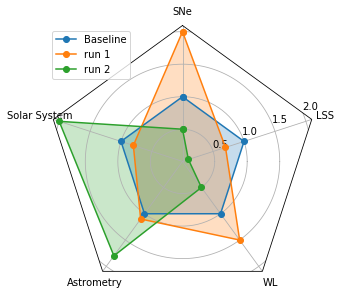

In [104]:
fig, axes = plt.subplots(figsize=(5, 5), subplot_kw=dict(projection='radar'))
axes.set_rgrids([0.5, 1.0, 1.5, 2.0])

data = [baseline[key] for key in names]
axes.plot(theta, data, 'o-', label='Baseline')
axes.fill(theta, data, alpha=0.25)

data = [run1[key] for key in names]
axes.plot(theta, data, 'o-', label='run 1')
axes.fill(theta, data,  alpha=0.25)

data = [run2[key] for key in names]
axes.plot(theta, data, 'o-', label='run 2')
axes.fill(theta, data,  alpha=0.25)


axes.set_varlabels(names)
axes.legend()

In [83]:
# Now from here: https://www.kaggle.com/typewind/draw-a-radar-chart-with-python-in-a-simple-way
data = [baseline[key] for key in names]

angles=np.linspace(0, 2*np.pi, len(names), endpoint=False)
# close the plot
stats=np.concatenate((data,[data[0]]))
angles=np.concatenate((angles,[angles[0]]))

data2 = [run1[key] for key in names]
stats2 = np.concatenate((data2,[data2[0]]))

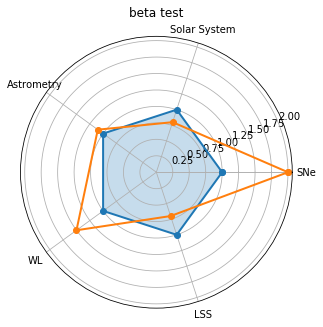

In [84]:
fig, ax = plt.subplots(figsize=(5, 5), subplot_kw=dict(projection='polar'))
ax.plot(angles, stats, 'o-', linewidth=2)
ax.plot(angles, stats2, 'o-', linewidth=2)

ax.fill(angles, stats, alpha=0.25)
ax.set_thetagrids(angles * 180/np.pi, names)
ax.set_title('beta test')
ax.grid(True)

In [86]:
np.degrees(angles)

array([  0.,  72., 144., 216., 288.,   0.])